# Avalanches accidents extraction

We load the avalanche accidents into a dataframe. It contains avalanche accidents location, elevation, aspect, danger level, number of people caught, buried and killed. We also downloaded the exact locations and we merge the two dataframes.

In [1]:
import numpy as np
import pandas as pd
import folium
import branca
import json
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load avalanche accidents data
df_accidents = pd.read_excel('../data/accidents/raw_accidents.xlsx')
df_accidents.head()

,Date,Canton,Starting zone,Elevation,Aspect,Activity,Danger level,caught,buried,killed
0,1997-10-26,BE,Kandersteg,3420,N,1,-,2,1.0,2
1,1997-12-19,GR,St. Moritz,2560,SW,2,3,2,1.0,1
2,1997-12-21,UR,Andermatt,2940,NW,3,4,2,1.0,1
3,1997-12-29,VS,Bagnes,2435,NE,1,3,2,2.0,1
4,1998-01-04,UR,Andermatt,2400,N,2,3,2,1.0,1


We parse the date

In [3]:
df_accidents['Date'] = pd.to_datetime(df_accidents['Date'])

We need to do some data cleaning on the danger level. Sometimes they are negative or not present

In [4]:
# Data cleaning
changing_danger = (df_accidents['Danger level'].str.contains('↗︎') == True)  # == True needed here
df_accidents.loc[changing_danger, 'Danger level'] = df_accidents.loc[changing_danger, 'Danger level'].str[0]
df_accidents['Danger level'] = df_accidents['Danger level'].replace('-',np.nan)
df_accidents['Danger level'] = pd.to_numeric(df_accidents['Danger level'])
df_accidents['Danger level'] = df_accidents['Danger level'].abs()

We also map the activities index to some more meaningful categories

| Index | Category |
| --- | --- |
| 1 | Backcountry touring (incl. for instance snow-shoeing, mountaineering)|
| 2 | Off-piste skiing and snowboarding (access generally from a ski area) |
| 3 | Transportation corridors (including for instance ski runs or roads) | 
| 4 | Buildings |

In [5]:
df_accidents['Activity'] = df_accidents['Activity'].replace({
    1: 'Backcountry touring',
    2: 'Off-piste skiing',
    3: 'Transportation',
    4: 'Buildings'
})

In [6]:
df_accidents.head()

,Date,Canton,Starting zone,Elevation,Aspect,Activity,Danger level,caught,buried,killed
0,1997-10-26,BE,Kandersteg,3420,N,Backcountry touring,NaN,2,1.0,2
1,1997-12-19,GR,St. Moritz,2560,SW,Off-piste skiing,3.0,2,1.0,1
2,1997-12-21,UR,Andermatt,2940,NW,Transportation,4.0,2,1.0,1
3,1997-12-29,VS,Bagnes,2435,NE,Backcountry touring,3.0,2,2.0,1
4,1998-01-04,UR,Andermatt,2400,N,Off-piste skiing,3.0,2,1.0,1


We create the Swiss map with the datapoints visualized.

In [7]:
# Create map centered on Switzerland
switzerland = (46.875893, 8.289321)
m = folium.Map(location=switzerland, zoom_start=8, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}', attr='Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ')

In order to locate each avalanche accident on the swiss map, we decided to use geopy in order to find the latitude and longitude correponding to each city name in the dataframe.

In [8]:
# Find coordinates for each avanlanche accident in Switzerland
coordinates = pd.read_excel('../data/accidents/coordinates.xlsx')

# Coordinates are added to the dataframe for each accident
df_accidents = df_accidents.assign(Longitude = coordinates.Longitude, Latitude = coordinates.Latitude)
df_accidents.head()

,Date,Canton,Starting zone,Elevation,Aspect,Activity,Danger level,caught,buried,killed,Latitude,Longitude
0,1997-10-26,BE,Kandersteg,3420,N,Backcountry touring,NaN,2,1.0,2,46.469813,7.728972
1,1997-12-19,GR,St. Moritz,2560,SW,Off-piste skiing,3.0,2,1.0,1,46.502976,9.772840
2,1997-12-21,UR,Andermatt,2940,NW,Transportation,4.0,2,1.0,1,46.602754,8.612660
3,1997-12-29,VS,Bagnes,2435,NE,Backcountry touring,3.0,2,2.0,1,46.034050,7.199696
4,1998-01-04,UR,Andermatt,2400,N,Off-piste skiing,3.0,2,1.0,1,46.617105,8.616889


For each accident, a marker is added on the map at the right location, with popups giving information about the starting zone, the elevation, the danger level, the number of people caught and killed.

In [9]:
import branca.colormap as cm

colors = ['#CCFF66','#FFFF00','#FF9B00', '#FF0000', '#800080']

colorscale = cm.StepColormap(
    colors,
    vmin=0., vmax=5.,
    index=range(6),
    caption="Avalanche Danger Level"
)

for i, values in df_accidents.iterrows():
    information = [
        ("Date", values["Date"].strftime("%Y-%m-%d")),
        ("Starting zone", values["Starting zone"]),
        ("Elevation", values["Elevation"]),
        ("Danger level", int(values["Danger level"]) if not np.isnan(values["Danger level"]) else "None"),
        ("Caught", values["caught"]),
        ("Killed", values["killed"]),
    ]
    
    pop_up = folium.Popup("<dl>" + ''.join(["<dt>{}: </dt><dd>{}</dd>".format(k, v) for k, v in information]) + "</dl>")
    color_circle = colorscale(values['Danger level']) if values['Danger level'] >= 1 else '#808080'
    location = [values.Latitude, values.Longitude]
    folium.CircleMarker(location, popup=pop_up, color=color_circle, radius=5).add_to(m)

In [10]:
m.add_child(colorscale)
m

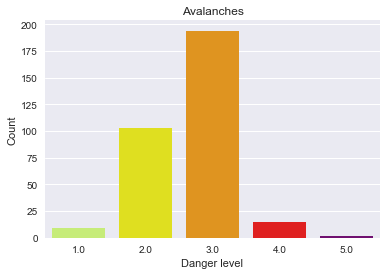

In [11]:
fig, ax = plt.subplots(1, sharey=True);

sns.countplot(x="Danger level", data=df_accidents, ax=ax, palette=colors);
ax.set_title('Avalanches');
ax.set_xlabel('Danger level');
ax.set_ylabel('Count');

In [12]:
m.save('accidents_map.html')

In [20]:
df_accidents.to_excel('../data/accidents/df_accidents.xlsx')